In [2]:
#reading the data
import pandas as pd

btc_blockchain_data = pd.read_csv("cryptoCompareData/btc_blockchain_data.csv", thousands=',').add_suffix("_btc_blockchain")
btc_prices= pd.read_csv("cryptoCompareData/btc_prices.csv", thousands=',').add_suffix("_btc_prices")
btc_social = pd.read_csv("cryptoCompareData/btc_social.csv", thousands=',').add_suffix("_btc_social")

eth_blockchain_data = pd.read_csv("cryptoCompareData/eth_blockchain_data.csv", thousands=',').add_suffix("_eth_blockchain")
eth_prices = pd.read_csv("cryptoCompareData/eth_prices.csv", thousands=',').add_suffix("_eth_prices")
eth_social = pd.read_csv("cryptoCompareData/eth_social.csv", thousands=',').add_suffix("_eth_social")


In [3]:
#merging all dataframes into one big dataframe based on time

read_data : pd.DataFrame = btc_blockchain_data\
    .merge(btc_prices,left_on='time_btc_blockchain', right_on='time_btc_prices',how='outer')\
    .merge(btc_social,left_on='time_btc_blockchain', right_on='time_btc_social',how='outer')\
    .merge(eth_blockchain_data,left_on='time_btc_blockchain', right_on='time_eth_blockchain',how='outer')\
    .merge(eth_prices,left_on='time_btc_blockchain', right_on='time_eth_prices',how='outer')\
    .merge(eth_social,left_on='time_btc_blockchain', right_on='time_eth_social',how='outer')
#drop missing btc prices and create only one time column
read_data.dropna(subset=["open_btc_prices"], inplace=True)
read_data.drop(columns=['time_btc_social','time_eth_social','time_eth_blockchain','time_btc_blockchain','time_eth_prices'], inplace=True)
read_data.rename(mapper={'time_btc_prices' : 'time'}, axis=1, inplace=True)
read_data.reset_index(inplace=True, drop=True)

#_all_time features encode the same information as new_ columns. Lets keep the all_time columns
read_data.drop(columns=['new_addresses_btc_blockchain','new_addresses_eth_blockchain'],inplace=True)

#last row has a lot of missing values on the day of download
read_data.drop(index=len(read_data)-1, inplace=True)

#twitter_following_eth_social has only 0.0 values
read_data.drop(columns=['twitter_following_eth_social'],inplace=True)

read_data

,zero_balance_addresses_all_time_btc_blockchain,unique_addresses_all_time_btc_blockchain,active_addresses_btc_blockchain,transaction_count_btc_blockchain,transaction_count_all_time_btc_blockchain,large_transaction_count_btc_blockchain,average_transaction_value_btc_blockchain,block_height_btc_blockchain,hashrate_btc_blockchain,difficulty_btc_blockchain,...,twitter_followers_eth_social,twitter_lists_eth_social,twitter_favourites_eth_social,twitter_statuses_eth_social,reddit_subscribers_eth_social,reddit_active_users_eth_social,reddit_posts_per_hour_eth_social,reddit_posts_per_day_eth_social,reddit_comments_per_hour_eth_social,reddit_comments_per_day_eth_social
0,34727.0,8.697900e+04,804.0,408.0,87062.0,0.0,80.264412,68779.0,1.587748e-03,1.815433e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35257.0,8.744600e+04,917.0,420.0,87482.0,0.0,106.357357,68951.0,1.624739e-03,1.815433e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,35744.0,8.805100e+04,972.0,528.0,88010.0,0.0,105.776042,69125.0,1.577979e-03,1.815433e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,36257.0,8.872500e+04,906.0,594.0,88604.0,0.0,65.576330,69306.0,1.633687e-03,1.815433e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36679.0,8.919400e+04,809.0,463.0,89067.0,0.0,82.083240,69513.0,1.865885e-03,1.815433e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4384,979064041.0,1.020915e+09,874433.0,247895.0,749885074.0,16024.0,13.348987,745547.0,1.938402e+08,2.915280e+13,...,2689200.0,12129.0,2178.0,3399.0,1347073.0,1027.0,0.67,16.04,10.64,255.27
4385,979539755.0,1.021336e+09,998065.0,279950.0,750165024.0,19400.0,11.882659,745685.0,2.025268e+08,2.915280e+13,...,2692214.0,12141.0,2178.0,3399.0,1348478.0,2588.0,0.62,14.86,19.60,470.51
4386,979905692.0,1.021727e+09,920079.0,260195.0,750425219.0,19468.0,9.892556,745811.0,1.860657e+08,2.915280e+13,...,2694799.0,12148.0,2178.0,3399.0,1349850.0,2595.0,0.66,15.87,14.55,349.11
4387,980324206.0,1.022140e+09,965128.0,273976.0,750699195.0,16926.0,13.723526,745950.0,2.001922e+08,2.882714e+13,...,2697167.0,12156.0,2178.0,3399.0,1351196.0,2641.0,0.67,16.18,14.13,339.05


# <font color='green'> Correlations: </font>
## <font color='green'> Time: </font>

In [4]:
#TIME
import numpy as np
#maybe more trade is being done on weekends
read_data['time'] = pd.to_datetime(read_data['time'])
read_data['dayOfTheWeek'] = read_data['time'] .dt.dayofweek
read_data['dayOfTheWeekCosine'] = np.cos(read_data['time'] .dt.dayofweek -6) #peak of cosine is at saturday
read_data['isWeekDay'] = (read_data['dayOfTheWeek'] < 5).astype(int)
print('Day representation correlations')
read_data.corr()['close_btc_prices'].iloc[-3:].sort_values(ascending=False)

Day representation correlations


isWeekDay             0.000624
dayOfTheWeekCosine   -0.000416
dayOfTheWeek         -0.000514
Name: close_btc_prices, dtype: float64

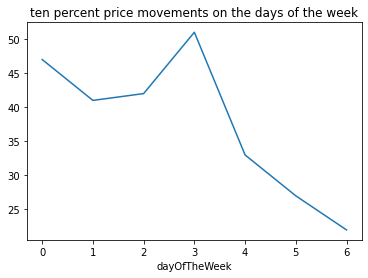

In [5]:
read_data["ten_percent_movements"] = np.abs(read_data['close_btc_prices'].pct_change()) >= 0.1
groupweek = read_data.groupby(['ten_percent_movements','dayOfTheWeek']).count()
groupweek.xs(True)['close_btc_prices'].plot(title='ten percent price movements on the days of the week');

##### There are less big movements on weekends (low sample size tho)
## <font color='green'> Examining downloaded features </font>

##### looking for correlations only in the last n days
##### because, since almost every feature has been trending upwards since the start
##### correlations may be deceiving

In [6]:
last_n_days = 3*365
close_btc_correlations = read_data[-last_n_days : ].corr()[['close_btc_prices']].sort_values("close_btc_prices",ascending=False,na_position='first')
close_btc_correlations

,close_btc_prices
twitter_followers_btc_social,NaN
twitter_following_btc_social,NaN
twitter_lists_btc_social,NaN
twitter_favourites_btc_social,NaN
twitter_statuses_btc_social,NaN
...,...
block_time_eth_blockchain,-0.174265
transaction_count_btc_blockchain,-0.401633
fb_talking_about_btc_social,-0.473665
fb_likes_btc_social,-0.487663


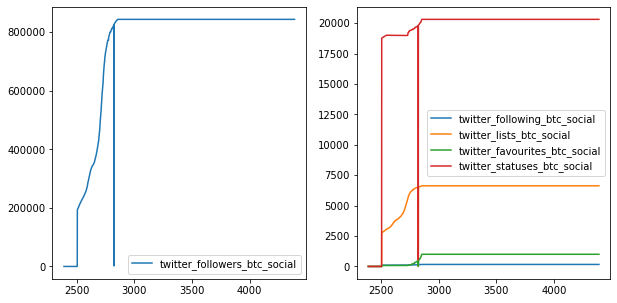

In [7]:
import matplotlib.pyplot as plt
f,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(read_data['twitter_followers_btc_social'],label='twitter_followers_btc_social')
axes[0].legend()
axes[1].plot(read_data['twitter_following_btc_social'],label='twitter_following_btc_social')
axes[1].plot(read_data['twitter_lists_btc_social'],label='twitter_lists_btc_social')
axes[1].plot(read_data['twitter_favourites_btc_social'],label='twitter_favourites_btc_social')
axes[1].plot(read_data['twitter_statuses_btc_social'],label='twitter_statuses_btc_social')
plt.legend()

##### this data looks very bad and incomplete so I will drop these columns;

In [8]:
merged = read_data.drop(columns=['twitter_followers_btc_social'
    ,'twitter_following_btc_social'
    ,'twitter_lists_btc_social'
    ,'twitter_favourites_btc_social'
    ,'twitter_statuses_btc_social'])

In [9]:
potentially_important_features = [] #this list will hold all columns which may be good for tranining based on correlations
above_90_percent_corr_columns = close_btc_correlations[close_btc_correlations['close_btc_prices'] > 0.9].index.tolist()
potentially_important_features += above_90_percent_corr_columns

### <font color='green'> large_transaction_count_btc_blockchain</font>
### <font color='green'> and large_transaction_count_eth_blockchain</font>

In [10]:
from typing import List


def plot_scatters_against(against : pd.Series, xs : List[pd.Series],against_name : str, names : List[str]):
    cols = 3
    rows = int(np.ceil(len(names)/float(cols)))
    fig, axs = plt.subplots(rows,cols,figsize=(15,5*len(names) // 3))

    for idx,col_name in enumerate(names):
        row_idx = idx // cols
        col_idx = idx%cols
        if len(names) > 3:
            ax = axs[row_idx,col_idx]
        else:
            ax = axs[col_idx]
        ax.set_ylabel(against_name,fontsize=14)
        ax.scatter(xs[idx], against)
        ax.set_title(col_name  + f" corr:{round(against.corr(xs[idx]),3)}",fontsize=14)
        ax.set_xlabel(col_name,fontsize=14)
        fig.tight_layout()

    return fig,axs

def plot_log_comparison(series1 : pd.Series, series2 : pd.Series, name1 : str, name2 : str, smooth_only_first=True):
    fig, axs = plt.subplots(2,2, figsize=(10,10))

    log1 = np.log(series1)
    log2 = np.log(series2)

    axs[0][0].plot(series1, label=f'{name1}')
    axs[0][0].plot(series2, label=f'{name2}')
    axs[0][0].set_xlabel('time',fontsize=16)
    axs[0][0].set_title(f'corr : {round(series1.corr(series2),2)}')
    axs[0][0].legend()

    axs[0][1].plot(log1, label=f'log {name1}')
    axs[0][1].plot(log2, label=f'log {name2}')
    axs[0][1].set_xlabel('time',fontsize=16)
    axs[0][1].set_title(f'corr : {round(log1.corr(log2),2)}')
    axs[0][1].legend()

    axs[1][0].scatter(log1, log2)
    axs[1][0].set_xlabel('log transactions',fontsize=16)
    axs[1][0].set_ylabel('log closing prices',fontsize=16)

    smooth_corrs = []
    smoothing_values = [1] + [i*3 for i in range(1,150)]
    for s_f in smoothing_values:
        smooth1 = log1.rolling(window=s_f,center=False).mean()
        if not smooth_only_first:
            smooth2 = log2.rolling(window=s_f,center=False).mean()
        else:
            smooth2 = log2
        smooth_corrs.append(smooth1.corr(smooth2))

    axs[1][1].plot(smoothing_values,smooth_corrs)
    axs[1][1].set_xlabel('smoothing factor (over time points)',fontsize=16)
    axs[1][1].set_ylabel('correlations',fontsize=16)
    axs[1][1].set_title('smoothing vs correlations',fontsize=16)


    return fig, axs



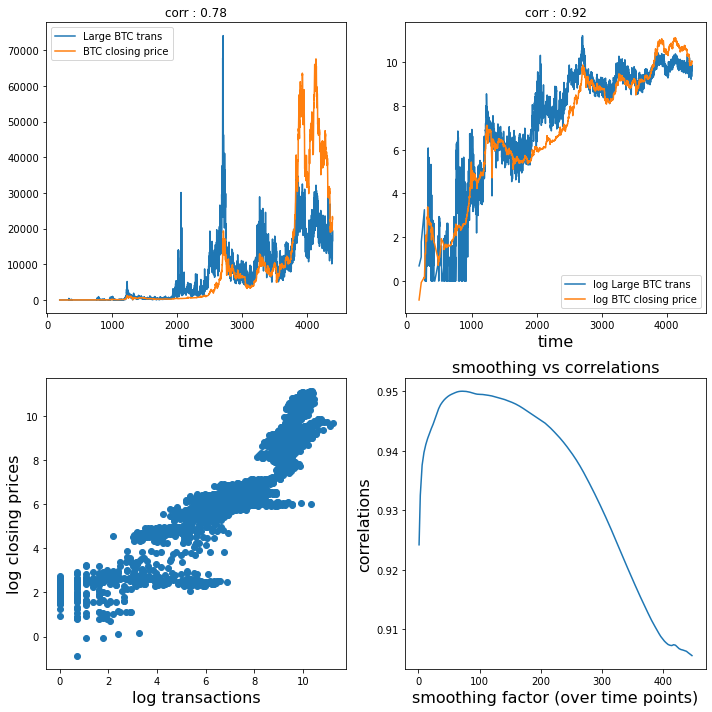

In [11]:
large_trans_btc =merged['large_transaction_count_btc_blockchain']
large_trans_eth =merged['large_transaction_count_eth_blockchain']

large_trans_btc = large_trans_btc[large_trans_btc != 0] #in the first ~800 days this column is 0.0

fig,axs = plot_log_comparison(large_trans_btc,merged['close_btc_prices'].iloc[large_trans_btc.index],'Large BTC trans','BTC closing price')
plt.tight_layout()

#### Log values correlate very nicely with a little smoothing

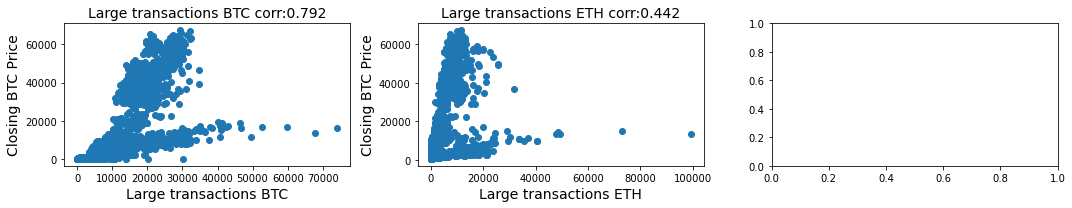

In [12]:
fig,axs = plot_scatters_against(merged['close_btc_prices'],
                                (merged['large_transaction_count_btc_blockchain'],merged['large_transaction_count_eth_blockchain']),
                                'Closing BTC Price',
                                ('Large transactions BTC','Large transactions ETH'))
plt.tight_layout()

#### There seem to be 2 lines which the values are on

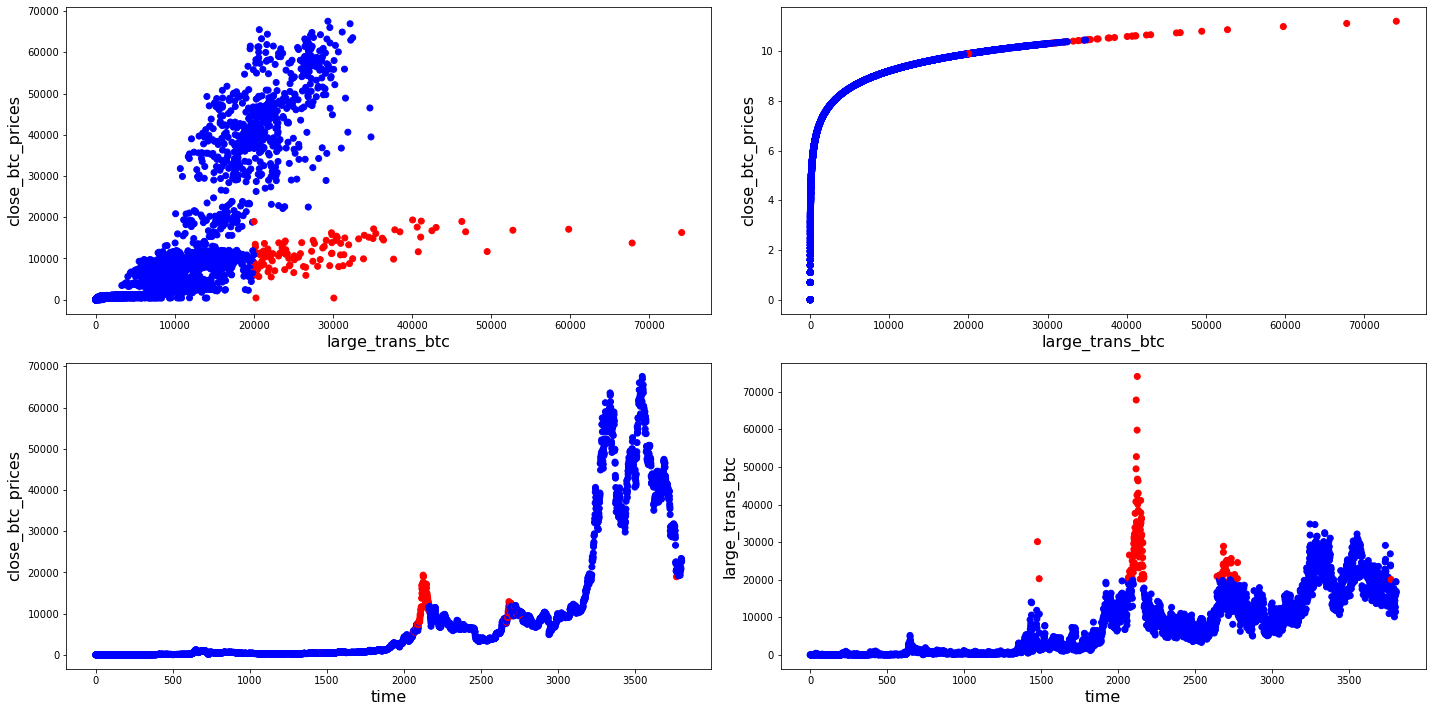

In [91]:
corresponding_closing_btc_prices = merged[['close_btc_prices']].loc[large_trans_btc.index].reset_index(drop=True)
btc_closing_under_20k = corresponding_closing_btc_prices.loc[corresponding_closing_btc_prices.close_btc_prices < 22000].index
large_trans_idx_reset = large_trans_btc.reset_index(drop=True)
large_trans_over_20k = large_trans_idx_reset.loc[large_trans_idx_reset > 20000].index

common_indices = [i for i in btc_closing_under_20k if i in large_trans_over_20k]
others = [i for i in btc_closing_under_20k if i not in large_trans_over_20k]

fig,axes = plt.subplots(2,2,figsize=(20,10))
colors = ['red' if i in common_indices else 'blue' for i in corresponding_closing_btc_prices.index]

axes[0][0].scatter(x=large_trans_btc,y=corresponding_closing_btc_prices['close_btc_prices'],color=colors)
axes[0][0].set_xlabel('large_trans_btc',fontsize=16)
axes[0][0].set_ylabel('close_btc_prices',fontsize=16)
axes[1][0].scatter(x=corresponding_closing_btc_prices.index,y=corresponding_closing_btc_prices['close_btc_prices'],color=colors)
axes[1][0].set_xlabel('time',fontsize=16)
axes[1][0].set_ylabel('close_btc_prices',fontsize=16)
large_trans_df = merged[['large_transaction_count_btc_blockchain']]
large_trans_df = large_trans_df[large_trans_df["large_transaction_count_btc_blockchain"] != 0].reset_index(drop=True)
large_trans_df['time'] = large_trans_df.index
axes[0][1].scatter(x=large_trans_btc,y=np.log(large_trans_df['large_transaction_count_btc_blockchain']),color=colors)
axes[0][1].set_xlabel('large_trans_btc',fontsize=16)
axes[0][1].set_ylabel('close_btc_prices',fontsize=16)
axes[1][1].scatter(x=large_trans_df.index,y=large_trans_df['large_transaction_count_btc_blockchain'],color=colors)
axes[1][1].set_xlabel('time',fontsize=16)
axes[1][1].set_ylabel('large_trans_btc',fontsize=16)
plt.tight_layout();

#### Seemingly during some spikes the two feature has a different correlation
#### but it may only be true for the hypes at the "start"

### <font color='green'> facebook talk:

btc close facebook talk-raw data -0.35663639450737933
btc facebook talk-corr with rolling mean -0.40202370417438016
eth close facebook talk-raw data -0.1453129464650602
eth close facebook talk-corr with rolling mean -0.1664749864136302


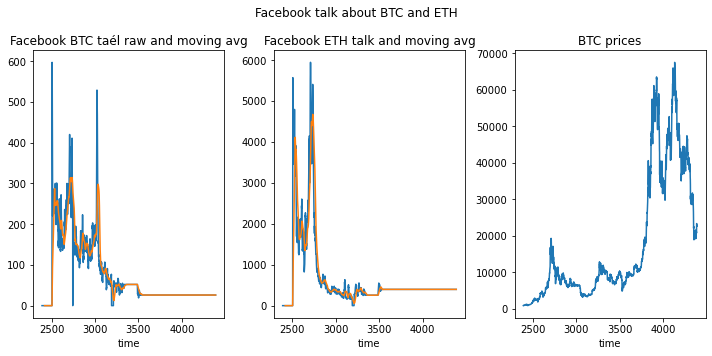

In [25]:
print("btc close facebook talk-raw data",merged['fb_talking_about_btc_social'].corr(merged['close_btc_prices']))
print("btc facebook talk-corr with rolling mean",merged['fb_talking_about_btc_social'].rolling(window=30).mean().corr(merged['close_btc_prices']))

print("eth close facebook talk-raw data",merged['fb_talking_about_eth_social'].corr(merged['close_btc_prices']))
print("eth close facebook talk-corr with rolling mean",merged['fb_talking_about_eth_social'].rolling(window=30).mean().corr(merged['close_btc_prices']))

fig, axs = plt.subplots(1,3, figsize=(10,5))
fig.suptitle('Facebook talk about BTC and ETH')

axs[0].plot(merged['fb_talking_about_btc_social'])
axs[0].plot(merged['fb_talking_about_btc_social'].rolling(window=30).mean())
axs[0].set_xlabel('time')
axs[0].set_title('Facebook BTC taél raw and moving avg')

axs[1].plot(merged['fb_talking_about_eth_social'])
axs[1].plot(merged['fb_talking_about_eth_social'].rolling(window=30).mean())
axs[1].set_title('Facebook ETH talk and moving avg')
axs[1].set_xlabel('time')

axs[2].plot(merged['close_btc_prices'][merged['fb_talking_about_btc_social'].notnull()])
axs[2].set_xlabel('time')
axs[2].set_title('BTC prices')

fig.tight_layout()

##### The negative correlations maybe due to the hype around 2017-2018 which calmed down while prices were rising.
##### This feature should probably be dropped.

### <font color='green'> Transaction values:

In [126]:
def plot_log_comparison(series1 : pd.Series, series2 : pd.Series, name1 : str, name2 : str, smooth_only_first=True):
    fig, axs = plt.subplots(2,2, figsize=(10,10))

    log1 = np.log(series1)
    log2 = np.log(series2)

    axs[0][0].plot(series1, label=f'{name1}')
    axs[0][0].plot(series2, label=f'{name2}')
    axs[0][0].set_xlabel('time',fontsize=16)
    axs[0][0].set_title(f'corr : {round(series1.corr(series2),2)}')
    axs[0][0].legend()

    axs[0][1].plot(log1, label=f'log {name1}')
    axs[0][1].plot(log2, label=f'log {name2}')
    axs[0][1].set_xlabel('time',fontsize=16)
    axs[0][1].set_title(f'corr : {round(log1.corr(log2),2)}')
    axs[0][1].legend()

    axs[1][0].scatter(log1, log2)
    axs[1][0].set_xlabel('log transactions',fontsize=16)
    axs[1][0].set_ylabel('log closing prices',fontsize=16)

    smooth_corrs = []
    smoothing_values = [1] + [i*3 for i in range(1,300)]
    for s_f in smoothing_values:
        smooth1 = log1.rolling(window=s_f,center=False).mean()
        if not smooth_only_first:
            smooth2 = log2.rolling(window=s_f,center=False).mean()
        else:
            smooth2 = log2
        smooth_corrs.append(smooth1.corr(smooth2))

    axs[1][1].plot(smoothing_values,smooth_corrs)
    axs[1][1].set_xlabel('smoothing factor (over time points)',fontsize=16)
    axs[1][1].set_ylabel('correlations',fontsize=16)
    axs[1][1].set_title('smoothing vs correlations',fontsize=16)


    return fig, axs


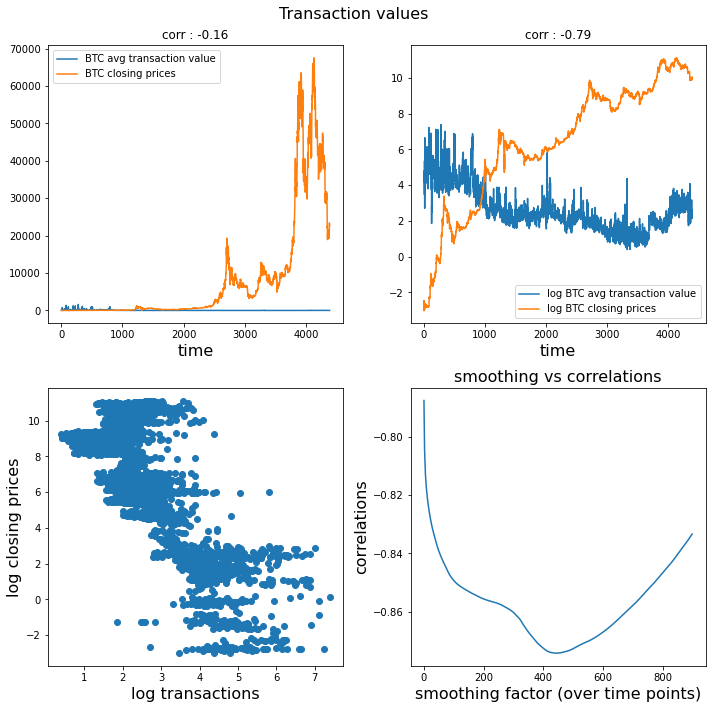

In [384]:
fig, axs = plot_log_comparison(merged['average_transaction_value_btc_blockchain']
                               ,merged['close_btc_prices']
                               ,'BTC avg transaction value'
                               ,'BTC closing prices'
                               ,smooth_only_first=True)

fig.suptitle('Transaction values ',fontsize=16)
plt.tight_layout()

##### The poor original correlation of the 2 series considerably improved when taking the respective logs.
##### Smoothing helps even more (with a window that only takes into account past values)
##### Could be useful even without smoothing.
##### ETH transaction values and their logs are probably a worse version of this feature

### <font color='green'> BTC traded To USD:

BTCTradedToUSD_btc_prices 0.0 values:
     BTCTradedToUSD_btc_prices       time  dayOfTheWeek
338                        0.0 2011-06-20             0
339                        0.0 2011-06-21             1
340                        0.0 2011-06-22             2
341                        0.0 2011-06-23             3
342                        0.0 2011-06-24             4
343                        0.0 2011-06-25             5


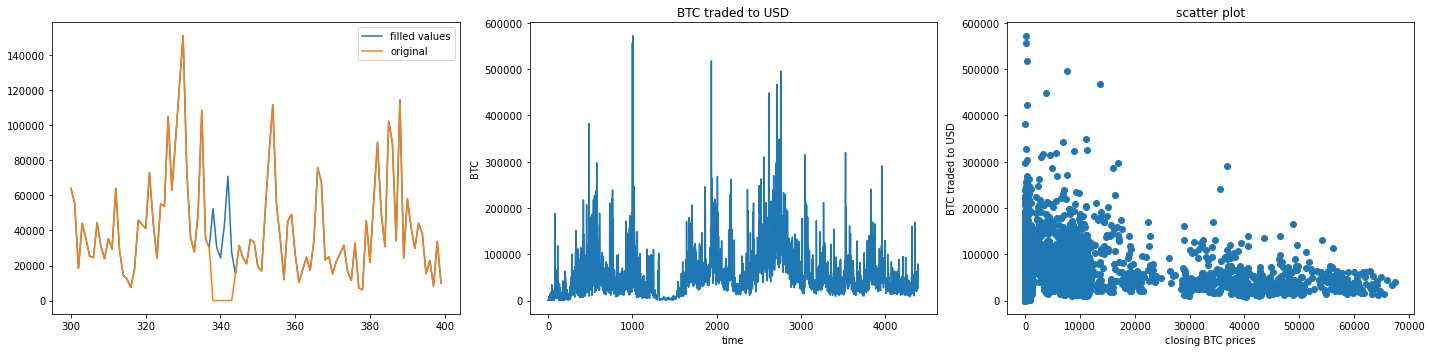

In [83]:
#for some reason we have 5 continuous day of 0.0 values
#replacing those with previous and next week's average of the same day at least for analysis
BTCTradedToUSD_btc_prices_nonnull = merged["BTCTradedToUSD_btc_prices"].copy()
BTCTradedToUSD_btc_prices_nonnull.loc[merged["BTCTradedToUSD_btc_prices"] == 0.0] \
    = (merged["BTCTradedToUSD_btc_prices"].shift(7) + merged["BTCTradedToUSD_btc_prices"].shift(-7))/2.0
#because we have 0.0 values for somre reason in a period and cannot the logarithm
print('BTCTradedToUSD_btc_prices 0.0 values:')
print(merged[['BTCTradedToUSD_btc_prices','time','dayOfTheWeek']].loc[merged["BTCTradedToUSD_btc_prices"] == 0.0])

fig,axs = plt.subplots(1,3,figsize=(20,5))
axs[0].plot(BTCTradedToUSD_btc_prices_nonnull.iloc[300:400],label='filled values')
axs[0].plot(merged["BTCTradedToUSD_btc_prices"].iloc[300:400],label='original')
axs[0].legend(loc='upper right')

axs[1].plot(BTCTradedToUSD_btc_prices_nonnull)
axs[1].set_title('BTC traded to USD')
axs[1].set_xlabel('time')
axs[1].set_ylabel('BTC')

axs[2].scatter(merged['close_btc_prices'],merged["BTCTradedToUSD_btc_prices"])
axs[2].set_title('scatter plot')
axs[2].set_ylabel('BTC traded to USD')
axs[2].set_xlabel('closing BTC prices')

plt.tight_layout()


log correlation: 0.29603159373746984
original correlation: -0.02875516311233268


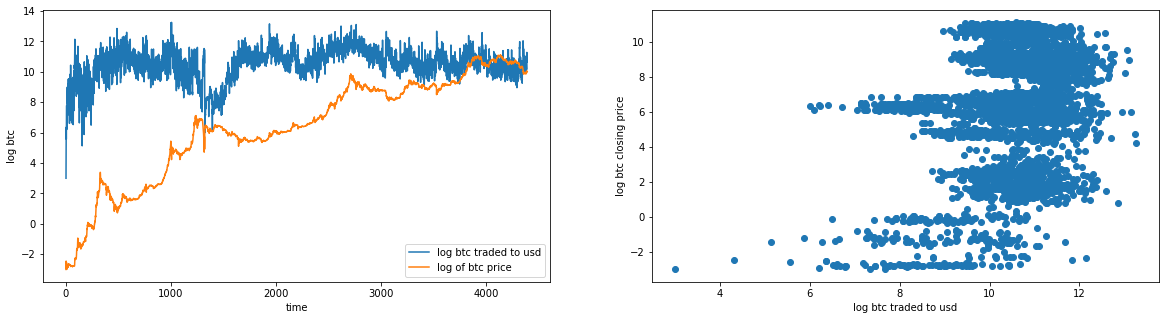

In [48]:
_,axs = plt.subplots(1,2,figsize=(20,5))

log_btc2usd = np.log(BTCTradedToUSD_btc_prices_nonnull)
axs[0].plot(log_btc2usd, label='log btc traded to usd')
log_btc_price = np.log(merged['close_btc_prices'])
axs[0].plot(log_btc_price, label='log of btc price')
axs[0].legend()
axs[0].set_xlabel('time')
axs[0].set_ylabel('log btc')

axs[1].scatter(log_btc2usd,log_btc_price)
axs[1].set_xlabel('log btc traded to usd')
axs[1].set_ylabel('log btc closing price')

print('log correlation:',log_btc_price.corr(log_btc2usd))
print('original correlation:',BTCTradedToUSD_btc_prices_nonnull.corr(merged['close_btc_prices']))

##### this feature does not correlate nicely with closing prices
##### probably should be dropped

### <font color='green'> BTC Transaction count:

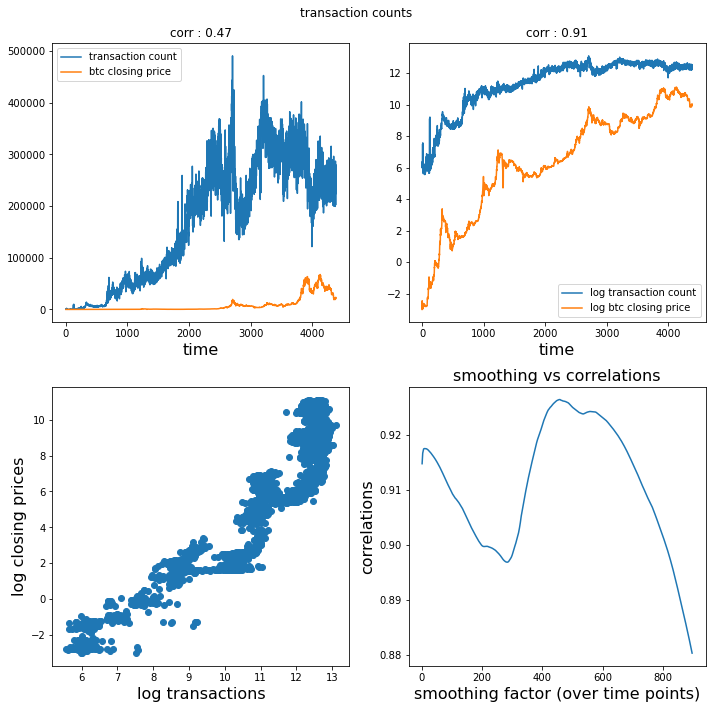

In [128]:
transaction_count = merged['transaction_count_btc_blockchain']


_, axes = plot_log_comparison(transaction_count
                    ,merged['close_btc_prices']
                    , 'transaction count'
                    ,'btc closing price'
                    ,smooth_only_first=True)
plt.suptitle('transaction counts')
plt.tight_layout()

##### The log of this feature has a nice correlation with closing prices (similarly to transaction value above)
##### The biggest correlation is with ~1+ year of smoothing which is very similar again to the transaction value series
##### Could be useful.

### <font color='green'> Large transaction count on the ETH blockchain:

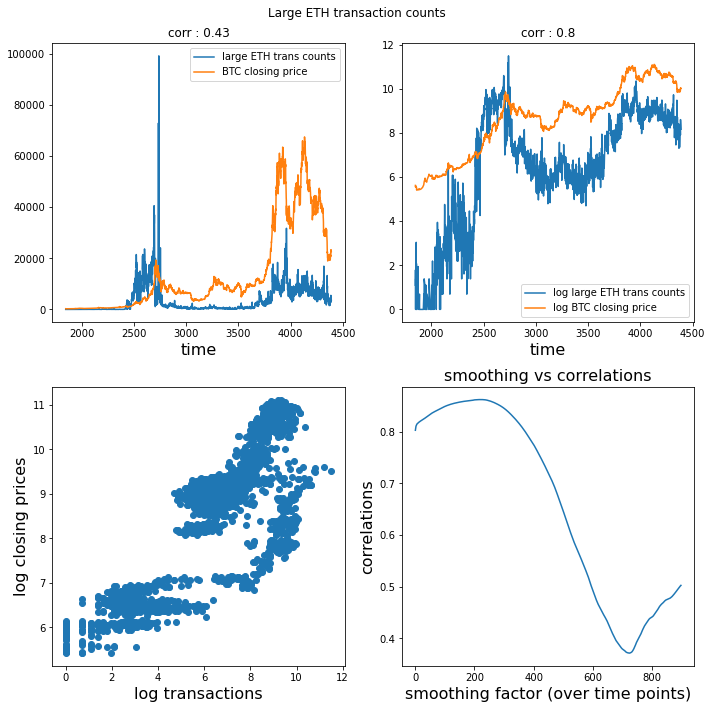

In [151]:
#lets just examine the values where eth existed and also did not have 0.0 values
large_eth_trans = merged['large_transaction_count_eth_blockchain']
large_eth_trans = large_eth_trans[(large_eth_trans != 0) & (large_eth_trans.notnull())]
cut_closing_btc_prices = merged['close_btc_prices'].iloc[large_eth_trans.index]

_,_ = plot_log_comparison(large_eth_trans,
                          cut_closing_btc_prices,
                          'large ETH trans counts',
                          'BTC closing price', smooth_only_first=True)
plt.suptitle('Large ETH transaction counts')
plt.tight_layout()

##### seems to have nice log correlation even without smoothing
##### could be useful.

### <font color='green'> Average transaction value BTC:

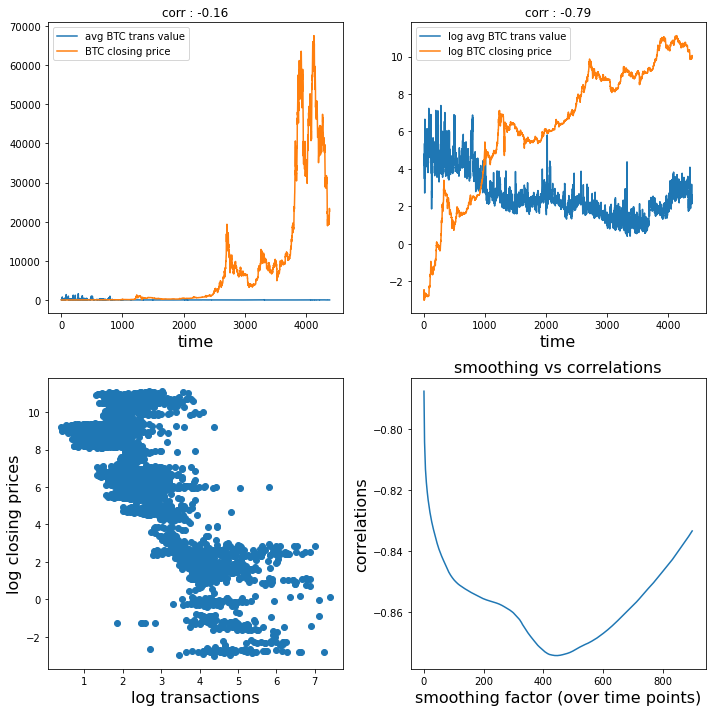

In [190]:
avg_btc_trans_value = merged['average_transaction_value_btc_blockchain']
_,_ = plot_log_comparison(avg_btc_trans_value
                          ,merged['close_btc_prices']
                          ,'avg BTC trans value'
                          ,'BTC closing price'
                          ,smooth_only_first=True)
plt.tight_layout()

##### very similar results to ETH transaction values

## <font color='green'> Examining high correlation features </font>

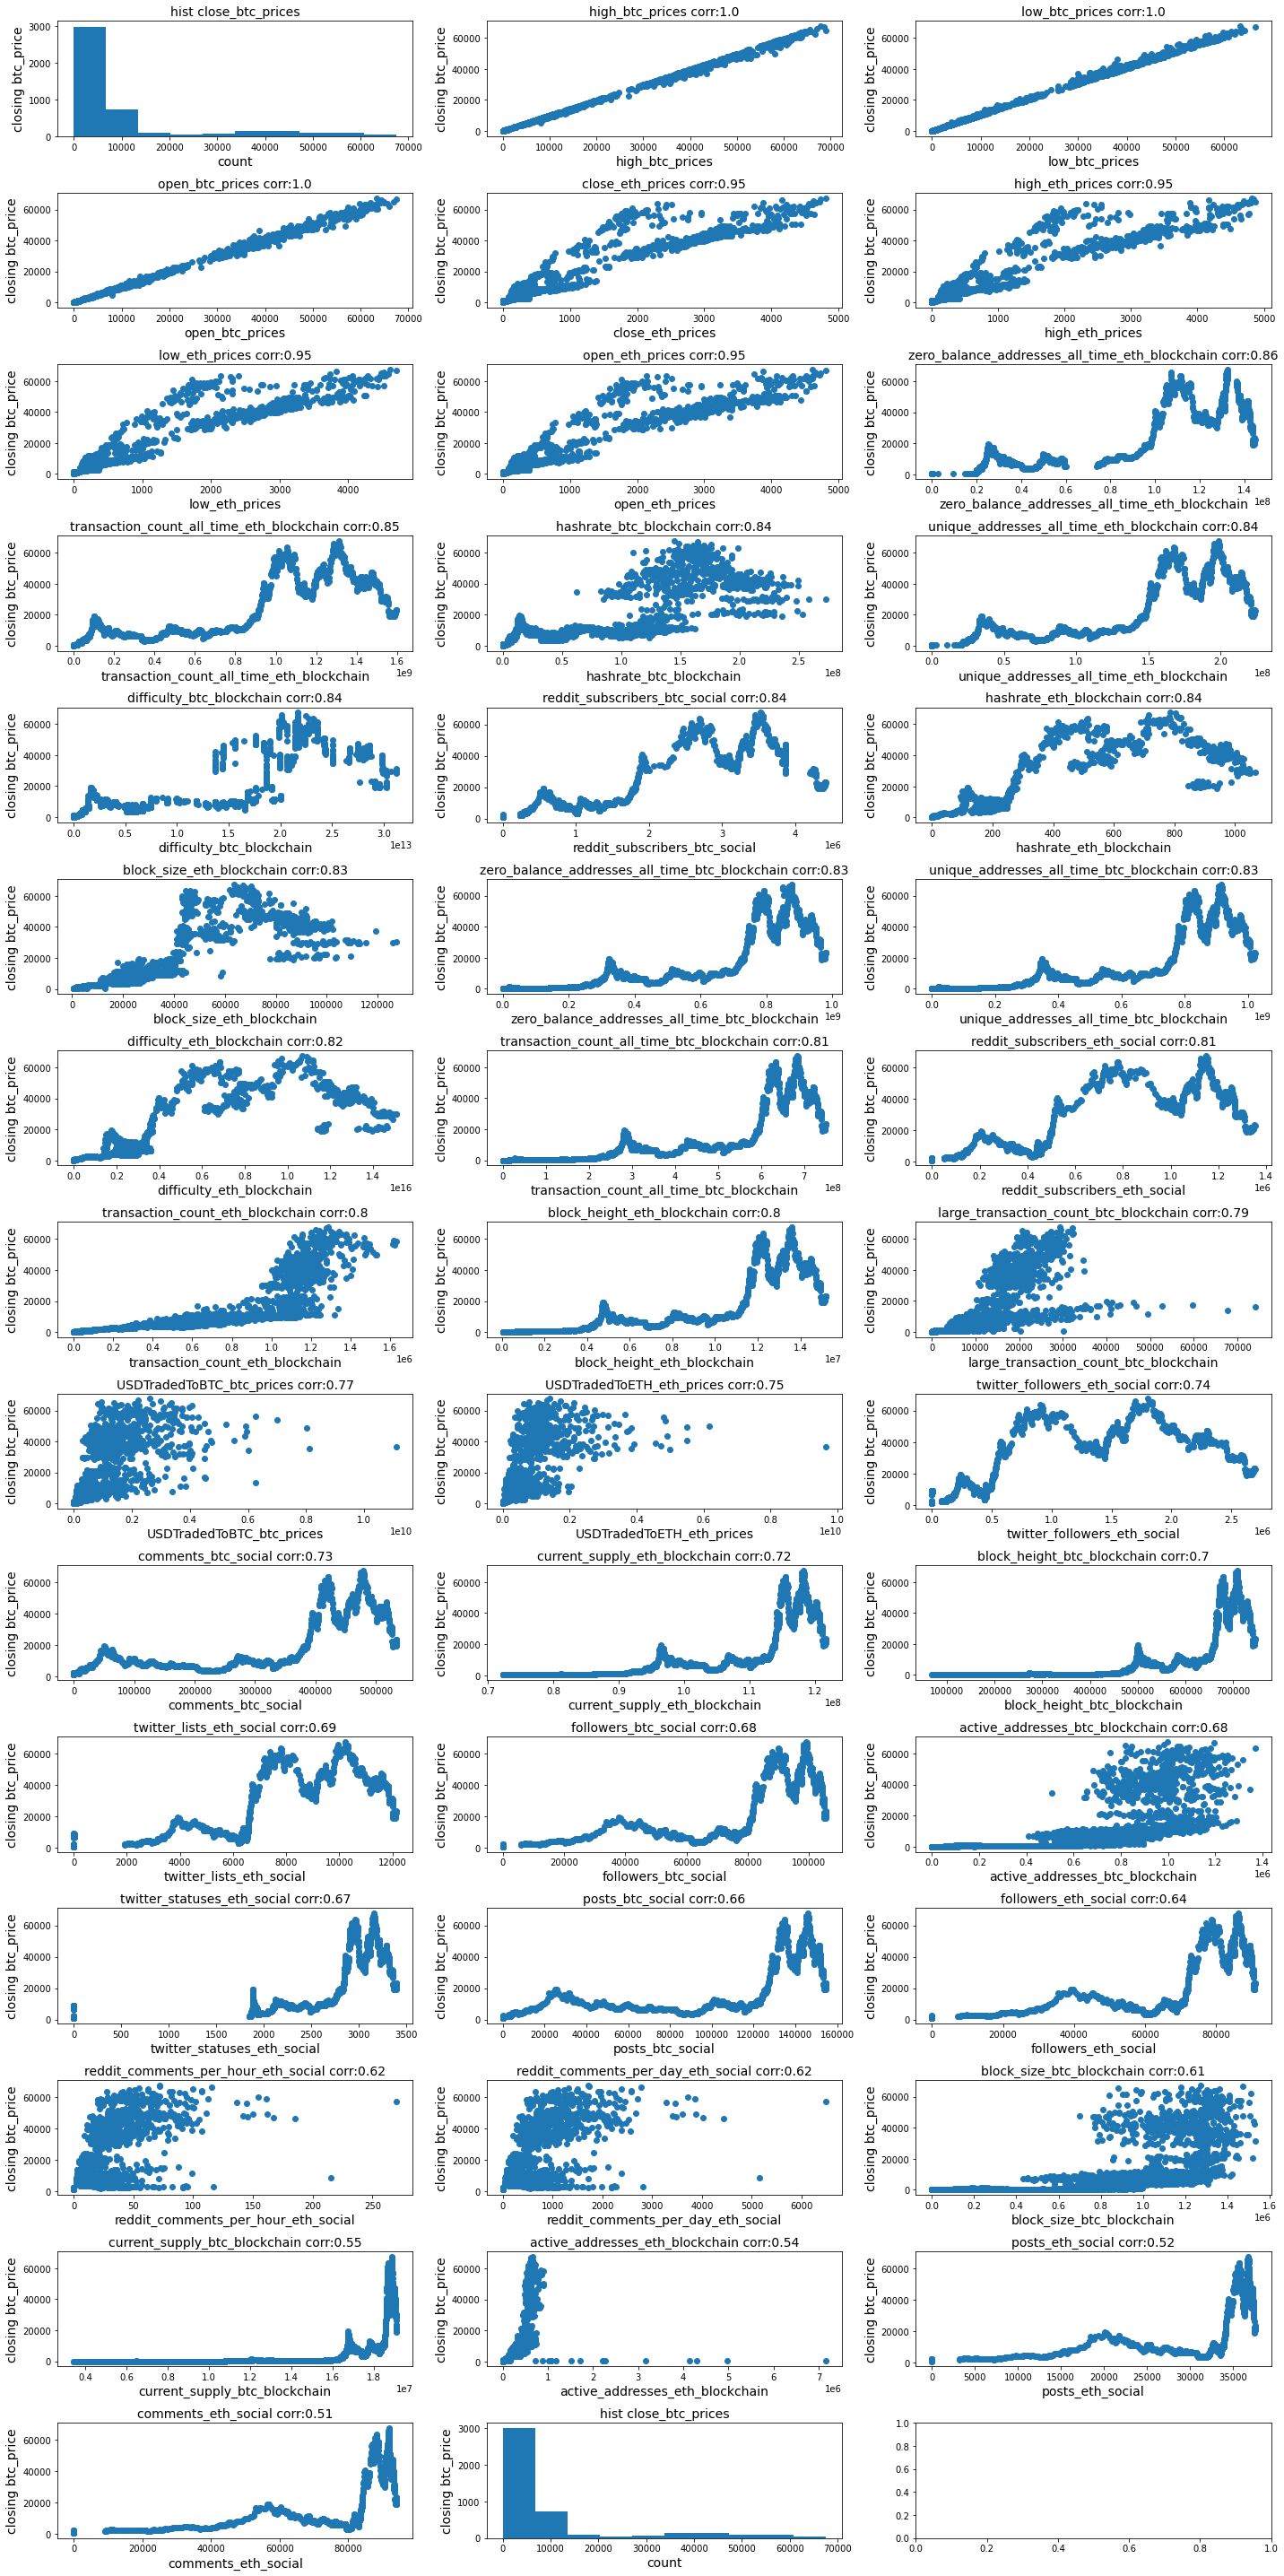

In [346]:
high_corr_column_names = close_btc_correlations[np.abs(close_btc_correlations['close_btc_prices'] >= 0.5 )].index.tolist()
examined_corrs = high_corr_column_names + ['close_btc_prices']


cols = 3
rows = int(np.ceil(len(examined_corrs)/float(cols)))
fig, axs = plt.subplots(rows,cols,figsize=(20,40))

for idx,col_name in enumerate(examined_corrs):
    row_idx = idx // cols
    col_idx = idx%cols
    ax = axs[row_idx,col_idx]
    ax.set_ylabel('closing btc_price',fontsize=14)
    if col_name == 'close_btc_prices':
        ax.hist(merged[col_name])
        ax.set_title("hist " + col_name,fontsize=14)
        ax.set_xlabel('count',fontsize=14)
    else:
        ax.scatter(merged[col_name], merged['close_btc_prices'])
        ax.set_title(col_name + f" corr:{round(close_btc_correlations.loc[col_name,:].iloc[0],2)}",fontsize=14)
        ax.set_xlabel(col_name,fontsize=14)
fig.tight_layout()

### <font color='green'> active_addresses_btc_blockchain </font>

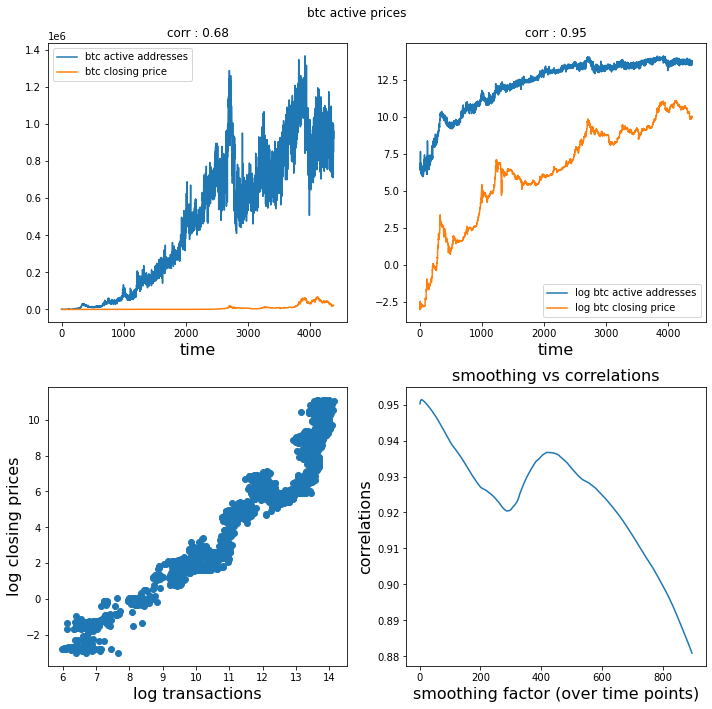

In [296]:
btc_active_addresses = merged['active_addresses_btc_blockchain'].copy()
fig, axes = plot_log_comparison(btc_active_addresses,merged['close_btc_prices'], 'btc active addresses','btc closing price')
plt.suptitle('btc active addresses')
plt.tight_layout()

##### unsmoothed / with small smoothing -  log values are highly correlated

### <font color='green'> active_addresses_eth_blockchain </font>

In [316]:
from scipy import stats
def get_pct_change_outliers(series : pd.Series, above_sigma):
    pct_changes = series.pct_change().replace([np.inf, -np.inf],0)
    return np.abs(stats.zscore(pct_changes,nan_policy='omit')) > above_sigma

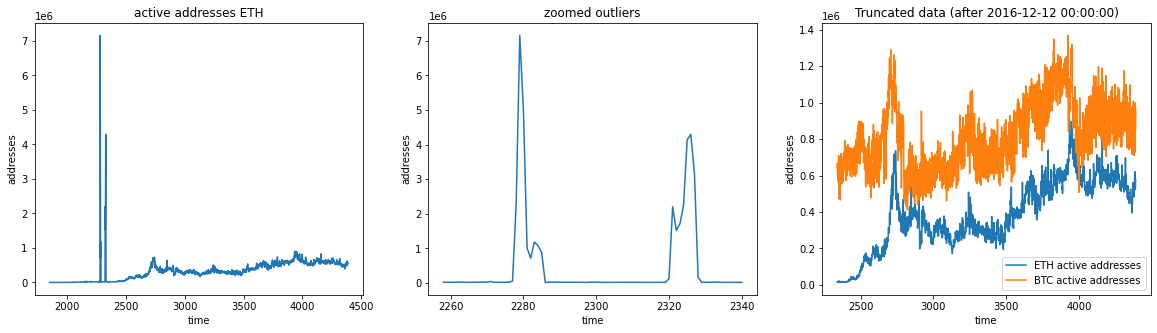

In [340]:
import matplotlib.pyplot as plt
eth_active_addresses = merged['active_addresses_eth_blockchain'].copy()
fig, axes = plt.subplots(1,3,figsize=(20,5))
axes[0].plot(eth_active_addresses)
axes[0].set_title('active addresses ETH')
axes[0].set_xlabel('time')
axes[0].set_ylabel('addresses')
outliers_idx = get_pct_change_outliers(eth_active_addresses,3)
min_idx = eth_active_addresses[outliers_idx].index.min()-20
max_idx = eth_active_addresses[outliers_idx].index.max()+20

axes[1].plot(eth_active_addresses.iloc[min_idx:max_idx])
axes[1].set_title('zoomed outliers')
axes[1].set_xlabel('time')
axes[1].set_ylabel('addresses')
cut_off_idx = 2340
eth_active_addresses[eth_active_addresses.index < cut_off_idx] = pd.NA

cut_date = merged['time'].iloc[cut_off_idx]
axes[2].plot(eth_active_addresses,label='ETH active addresses')
axes[2].plot(merged['active_addresses_btc_blockchain'].iloc[cut_off_idx : ],label='BTC active addresses')
axes[2].set_title(f'Truncated data (after {cut_date})')
axes[2].set_xlabel('time')
axes[2].set_ylabel('addresses')
axes[2].legend()

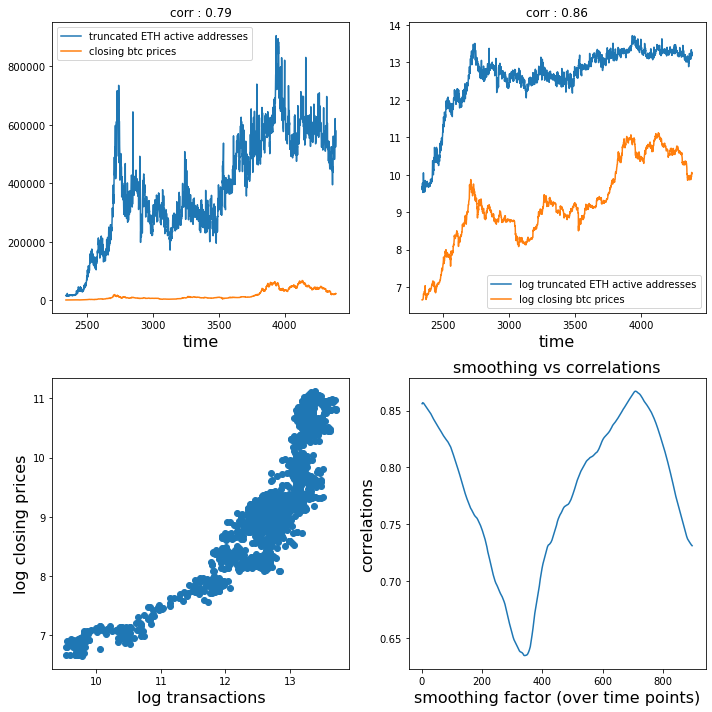

In [345]:
fig,axes = plot_log_comparison(eth_active_addresses.iloc[cut_off_idx : ]
                               ,merged['close_btc_prices'].iloc[cut_off_idx : ]
                               ,'truncated ETH active addresses',
                               'closing btc prices')
plt.tight_layout()

##### naturally active BTC addresses above have better correlations
##### the series seems to be lagging a bit after btc prices
##### so this might not be the best predictor anyway
##### nevertheless, it has good correlation as expected
##### but taking the log does not help as much as it did with the others

### <font color='green'> btc hashrate </font>

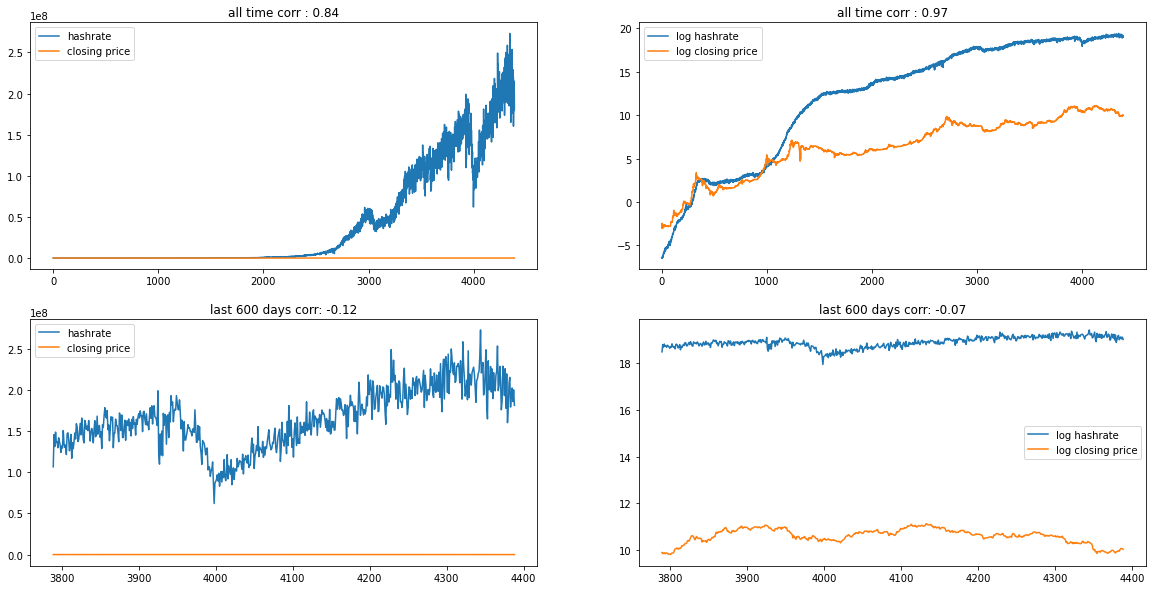

In [371]:
btc_hashrate = merged['hashrate_btc_blockchain']
fig, axes = plt.subplots(2,2, figsize=(20,10))

axes[0][0].plot(btc_hashrate,label='hashrate')
axes[0][0].plot(merged['close_btc_prices'],label='closing price')
axes[0][0].set_title(f'all time corr : {round(merged["close_btc_prices"].corr(btc_hashrate),2)}')
axes[0][0].legend()

axes[0][1].plot(np.log(btc_hashrate),label='log hashrate')
axes[0][1].plot(np.log(merged['close_btc_prices']),label='log closing price')
axes[0][1].set_title(f'all time corr : {round(np.log(merged["close_btc_prices"]).corr(np.log(btc_hashrate)),2)}')
axes[0][1].legend()

axes[1][0].plot(btc_hashrate.iloc[-600:],label='hashrate')
axes[1][0].plot(merged['close_btc_prices'].iloc[-600:],label='closing price')
axes[1][0].set_title(f'last 600 days corr: {round(merged["close_btc_prices"].iloc[-600:].corr(btc_hashrate.iloc[-600:]),2)}')
axes[1][0].legend()

axes[1][1].plot(np.log(btc_hashrate.iloc[-600:]),label='log hashrate')
axes[1][1].plot(np.log(merged['close_btc_prices'].iloc[-600:]),label='log closing price')
axes[1][1].set_title(f'last 600 days corr: {round(np.log(merged["close_btc_prices"].iloc[-600:]).corr(np.log(btc_hashrate.iloc[-600:])),2)}')
axes[1][1].legend()


##### The correlation was only due to the rise of both series
##### can be dropped

,close_btc_prices
close_btc_prices,1.000000
high_btc_prices,0.995504
low_btc_prices,0.994832
open_btc_prices,0.989810
close_eth_prices,0.711340
...,...
twitter_lists_btc_social,NaN
twitter_favourites_btc_social,NaN
twitter_statuses_btc_social,NaN
fb_likes_eth_social,NaN


In [396]:
merged['fb_talking_about_btc_social']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
4384    26.0
4385    26.0
4386    26.0
4387    26.0
4388    26.0
Name: fb_talking_about_btc_social, Length: 4389, dtype: float64